<a href="https://colab.research.google.com/github/Ygrick/Data-Science/blob/main/cats_vs_another.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Обучение

In [ ]:
# !pip install split-folders

In [ ]:
# import splitfolders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
from torch.utils.data import random_split, DataLoader
import numpy
import cv2
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# splitfolders.ratio('/content/drive/MyDrive/PetImages/Images', output='/content/drive/MyDrive/PetImages/Output', ratio=(0.8, 0.2), move=False)

In [ ]:
# os.remove('/content/drive/MyDrive/PetImages/Output/train/Cat/666.jpg')

In [ ]:
data_dir = '/content/drive/MyDrive/PetImages/Output'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.6, p=0.2),
        transforms.Pad(padding=100), # попробовать
        transforms.RandomHorizontalFlip(p=0.2),
        # transforms.RandomRotation(degrees=(0, 180)),
        transforms.Resize([256,256]),
        # transforms.to_grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]
                                          ) for x in ['train', 'val']
                  }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=2) for x in ['train', 'val']} # batch_size = 128 - самый лучший

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=7)

Epoch 0/6
----------
train Loss: 0.1039 Acc: 0.9649
val Loss: 0.0553 Acc: 0.9830
0

Epoch 1/6
----------
train Loss: 0.0314 Acc: 0.9900
val Loss: 0.0466 Acc: 0.9842
1

Epoch 2/6
----------
train Loss: 0.0252 Acc: 0.9920
val Loss: 0.0388 Acc: 0.9875
2

Epoch 3/6
----------
train Loss: 0.0209 Acc: 0.9940
val Loss: 0.0365 Acc: 0.9890
3

Epoch 4/6
----------
train Loss: 0.0164 Acc: 0.9948
val Loss: 0.0357 Acc: 0.9881

Epoch 5/6
----------
train Loss: 0.0166 Acc: 0.9945
val Loss: 0.0463 Acc: 0.9860

Epoch 6/6
----------
train Loss: 0.0124 Acc: 0.9961
val Loss: 0.0330 Acc: 0.9875

Training complete in 51m 16s
Best val Acc: 0.988975


### СВОДКА

<function matplotlib.pyplot.show>

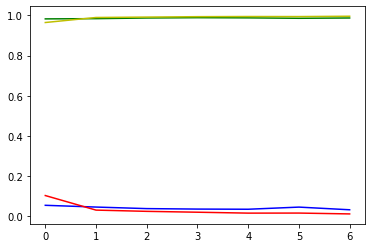

In [ ]:
plt.plot(val_loss, 'b')
plt.plot(train_loss, 'r')

plt.plot(val_acc, 'g')
plt.plot(train_acc, 'y')

plt.show

In [ ]:
model_ft.state_dict()

### СОХРАНЕНИЕ

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/igor_romaykin_cat_another_v2.pt')
# model_ft = torch.load('/content/drive/MyDrive/____.pt', map_location='cpu')

### Тест


In [ ]:
dir_group = '/content/drive/MyDrive/vk_api/pmmgo/'
images = []

test_data_transforms = (
        transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize([256,256]),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))


for file_name in os.listdir(dir_group):
  img = cv2.imread(os.path.join(dir_group, file_name))
  transform_image = test_data_transforms(img)
  images.append(transform_image)


In [ ]:
# model_ft.eval()
model_ft = model_ft.to('cpu')

In [ ]:
test_dataloaders = torch.utils.data.DataLoader(images)
predicts = []
for inputs in test_dataloaders:
  outputs = model_ft(inputs.to('cpu'))
  _, pred = torch.max(outputs, 1)
  predicts.append(pred)

In [ ]:
pred_list = list(map(lambda x: x.item(), predicts))
arr = numpy.array(pred_list)
len(arr)

274

ValueError: ignored

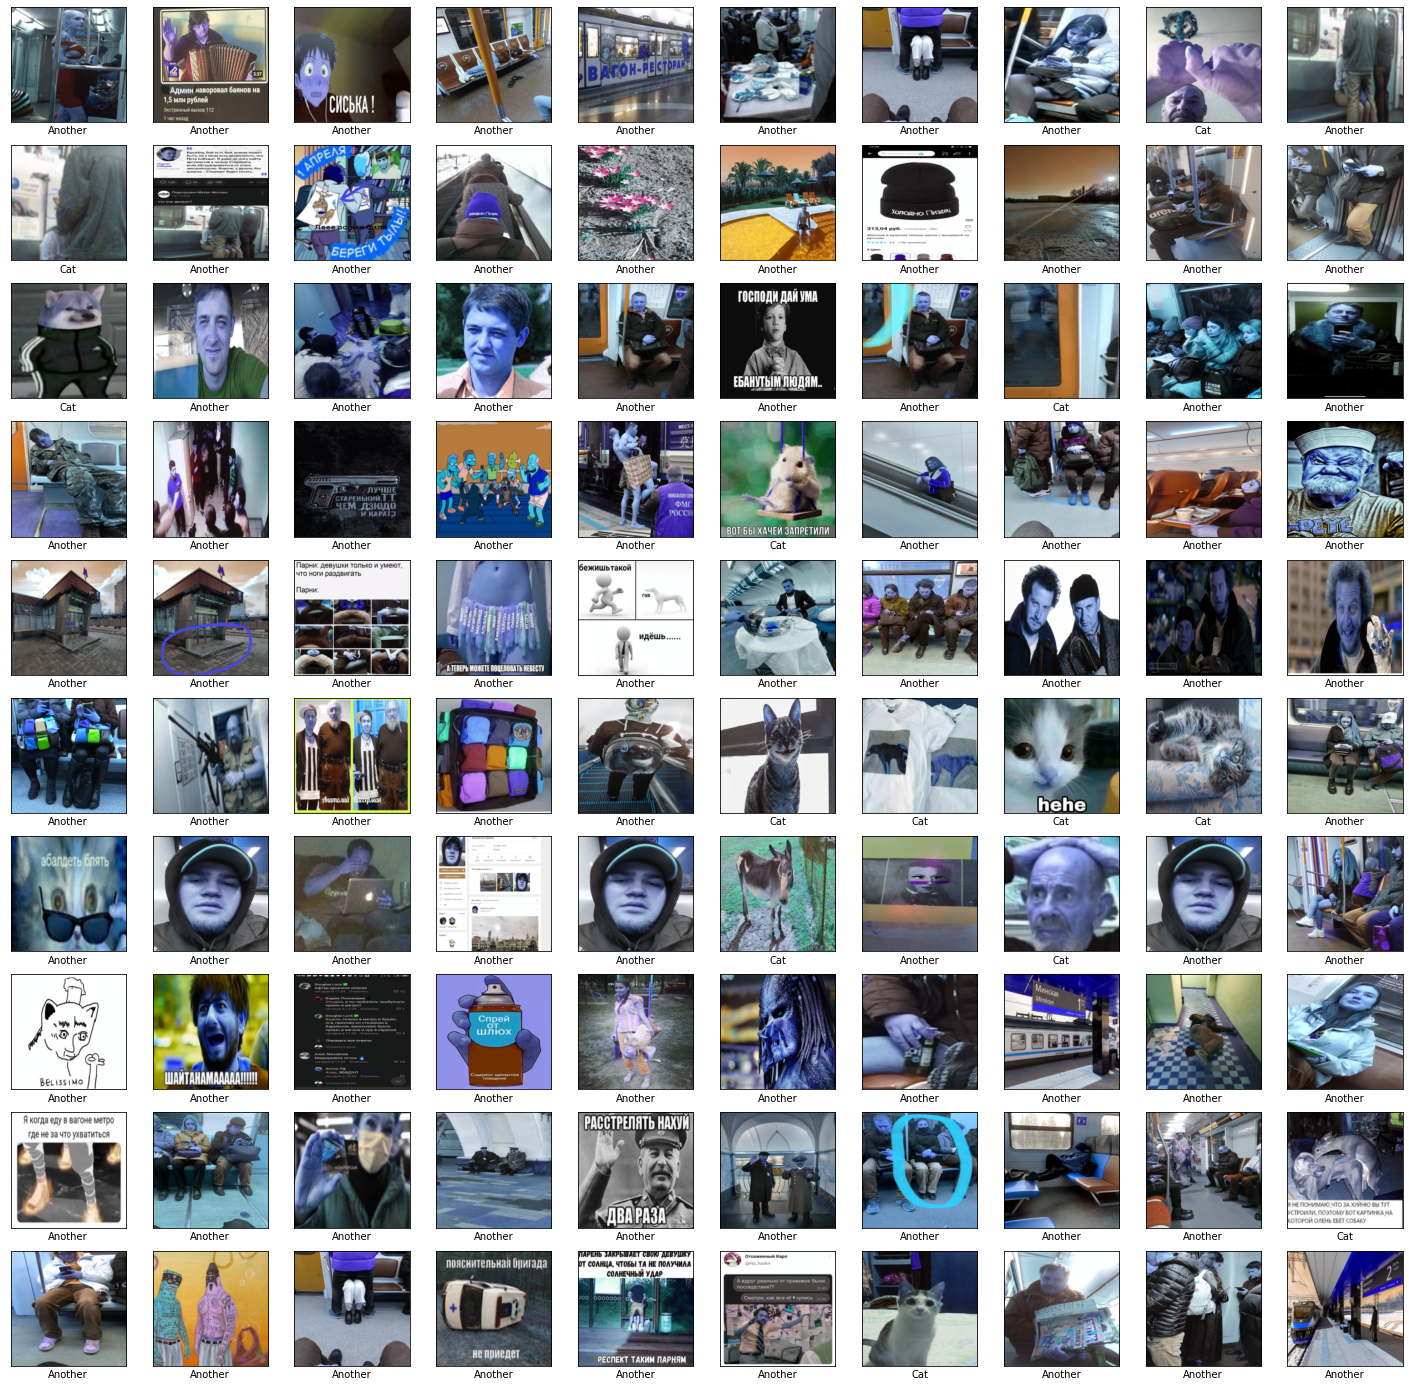

In [ ]:
plt.figure(figsize=(25, 25))
for i, inputs in enumerate(test_dataloaders):
  # if i > 48:
  #   break
  # создание полотна
  plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])

  # нормализация
  img = inputs[0].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)

  # отображение
  plt.imshow(img)
  plt.xlabel(class_names[arr[i]], fontsize=10)

### Предсказание

In [ ]:
info_of_group = {'casesmen': {'comments': 1.22, 'id': 165972901, 'members': 377635},
 'club148881515': {'comments': 0.02, 'id': 148881515, 'members': 699584},
 'club155622384': {'comments': 0.02, 'id': 155622384, 'members': 256322},
 'club160966228': {'comments': 0.02, 'id': 160966228, 'members': 476585},
 'club164570113': {'comments': 0.02, 'id': 164570113, 'members': 213751},
 'club76791337': {'comments': 0.02, 'id': 76791337, 'members': 731473},
 'fsb_overhear': {'comments': 426.98, 'id': 97336576, 'members': 262217},
 'girlrumors': {'comments': 310.64, 'id': 153312271, 'members': 207246},
 'intimate_fact': {'comments': 7.33, 'id': 35179056, 'members': 496836},
 'irknim': {'comments': 84.55, 'id': 47220519, 'members': 206945},
 'ispovedano': {'comments': 5.11, 'id': 53272975, 'members': 308767},
 'krsk_overhear': {'comments': 185.77, 'id': 59804801, 'members': 186316},
 'krskoverhear': {'comments': 16.35, 'id': 59717127, 'members': 176356},
 'metrooverhear': {'comments': 4.58, 'id': 79010330, 'members': 184554},
 'news_show_businesss': {'comments': 189.0, 'id': 159631764, 'members': 343534},
 'normilinet': {'comments': 21.78, 'id': 158707372, 'members': 231235},
 'orb_overhear': {'comments': 29.5, 'id': 61061413, 'members': 206361},
 'overhear': {'comments': 13.5, 'id': 34215577, 'members': 4031170},
 'overhear_cosmetics': {'comments': 29.36, 'id': 87822007, 'members': 270232},
 'overhear_hogwarts': {'comments': 3.24, 'id': 62418732, 'members': 271690},
 'overhear_in_football': {'comments': 7.58, 'id': 80142104, 'members': 344005},
 'overhear_police': {'comments': 16.37, 'id': 28464698, 'members': 251897},
 'overhear_women_secrets': {'comments': 7.85, 'id': 84808204, 'members': 392308},
 'overhear_wot': {'comments': 88.05, 'id': 61343704, 'members': 252652},
 'overheard_in_yaroslavl': {'comments': 2.82, 'id': 77004850, 'members': 336253},
 'overhearkazan': {'comments': 7.43, 'id': 26282259, 'members': 186521},
 'overhearmedic': {'comments': 25.27, 'id': 63005131, 'members': 193811},
 'overstory163': {'comments': 217.04, 'id': 42949290, 'members': 365591},
 'pmmgo': {'comments': 920.46, 'id': 144260965, 'members': 674921},
 'pmmjournal': {'comments': 139.59, 'id': 48540538, 'members': 256865},
 'podsluhano_vo_vladimire': {'comments': 30.21, 'id': 83678526, 'members': 187905},
 'podslushano_stroitelstvo': {'comments': 3.63, 'id': 44150887, 'members': 282219},
 'podslushano_y_mam': {'comments': 24.99, 'id': 64209172, 'members': 293972},
 'podslushanoklubromantiki': {'comments': 193.07, 'id': 94672807, 'members': 260251},
 'podslushanokrd': {'comments': 72.22, 'id': 29270122, 'members': 209458},
 'podslushanomama2016': {'comments': 76.78, 'id': 123403112, 'members': 192004},
 'podslushanoperm': {'comments': 175.2, 'id': 60397113, 'members': 479792},
 'podslushanovptz': {'comments': 0.68, 'id': 59517317, 'members': 175542},
 'podslushanovrostove': {'comments': 33.49, 'id': 62371937, 'members': 213854},
 'podslyshanobiss': {'comments': 29.35, 'id': 104144232, 'members': 280865},
 'publictiktokp5': {'comments': 14.95, 'id': 172936085, 'members': 207956},
 'sbpears': {'comments': 254.81, 'id': 67083068, 'members': 247583},
 'sch.story': {'comments': 16.69, 'id': 145515240, 'members': 266475},
 'secret_32': {'comments': 135.77, 'id': 72214520, 'members': 237275},
 'secrets_of_programmist': {'comments': 32.64, 'id': 76746437, 'members': 191460},
 'secretsem': {'comments': 605.9, 'id': 48263451, 'members': 194383},
 'showvk': {'comments': 6.25, 'id': 165631795, 'members': 260668},
 'ufa_overhear': {'comments': 104.54, 'id': 58343385, 'members': 249394},
 'yarchat': {'comments': 170.47, 'id': 64058969, 'members': 274462},
 'yumorxxl': {'comments': 35.63, 'id': 51090603, 'members': 223924}}

In [ ]:
name_list = []
cats_list = []
all_img_list = []
part_of_cats_list = []
mean_comments_list = []
members_list = []
score_list = []

test_data_transforms = (
        transforms.Compose([
          transforms.ToPILImage(),
          transforms.Resize([256,256]),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
for item in info_of_group:
  print(item)
  dir_group = f'/content/drive/MyDrive/vk_api/{item}/'
  images = []
  predicts = []

  for file_name in os.listdir(dir_group):
    img = cv2.imread(os.path.join(dir_group, file_name))
    transform_image = test_data_transforms(img)
    images.append(transform_image)

  test_dataloaders = torch.utils.data.DataLoader(images)

  for inputs in test_dataloaders:
    outputs = model_ft(inputs.to('cpu'))
    _, pred = torch.max(outputs, 1)
    predicts.append(pred)

  pred_list = list(map(lambda x: x.item(), predicts))
  arr = numpy.array(pred_list)
  if len(arr) != 0:
    part_of_cats = sum(arr)/len(arr)
    members = info_of_group[f'{item}']['members']
    mean_comments = info_of_group[f'{item}']['comments']
    metric = part_of_cats*mean_comments/members
    
    name_list.append(item)
    cats_list.append(sum(arr))
    all_img_list.append(len(arr))
    part_of_cats_list.append(round(part_of_cats, 5))
    mean_comments_list.append(mean_comments)
    members_list.append(members)
    score_list.append(round(metric, 5))

casesmen
club148881515
club155622384
club160966228
club164570113
club76791337
fsb_overhear
girlrumors
intimate_fact
irknim
ispovedano
krsk_overhear
krskoverhear
metrooverhear
news_show_businesss
normilinet
orb_overhear
overhear
overhear_cosmetics
overhear_hogwarts
overhear_in_football
overhear_police
overhear_women_secrets
overhear_wot
overheard_in_yaroslavl
overhearkazan
overhearmedic
overstory163
pmmgo
pmmjournal
podsluhano_vo_vladimire
podslushano_stroitelstvo
podslushano_y_mam
podslushanoklubromantiki
podslushanokrd
podslushanomama2016
podslushanoperm
podslushanovptz
podslushanovrostove
podslyshanobiss
publictiktokp5
sbpears
sch.story
secret_32
secrets_of_programmist
secretsem
showvk
ufa_overhear
yarchat
yumorxxl


In [ ]:
part_of_cats = sum(arr)/len(arr)
mean_comments = 920.46
members = 674921
metric = part_of_cats*mean_comments/members
result = {'cats': sum(arr),
          'all_img': len(arr),
          'part_of_cats': round(part_of_cats, 5),
          'mean_comments': mean_comments,
          'members': members,
          'score': round(metric, 5)
          }
result

{'all_img': 274,
 'cats': 23,
 'mean_comments': 920.46,
 'members': 674921,
 'part_of_cats': 0.08394,
 'score': 0.00011}

In [ ]:
name_list.append(item)
cats_list.append(sum(arr))
all_img_list.append(len(arr))
part_of_cats_list.append(round(part_of_cats, 5))
mean_comments_list.append(mean_comments)
members_list.append(members)
score_list.append(round(metric, 5))

df = pd.DataFrame(data={'имя_сообщества': name_list, 
                        'колво_котов': cats_list,
                        'колво_всех_изображений': all_img_list,
                        'доля_котов': part_of_cats_list,
                        'среднее_комментов': mean_comments_list,
                        'колво_участников': members_list,
                        'метрика': score_list
                        })
df 

,имя_сообщества,колво_котов,колво_всех_изображений,доля_котов,среднее_комментов,колво_участников,метрика
0,casesmen,1,112,0.00893,1.22,377635,0.00000
1,fsb_overhear,12,342,0.03509,426.98,262217,0.00006
2,girlrumors,1,45,0.02222,310.64,207246,0.00003
3,intimate_fact,2,9,0.22222,7.33,496836,0.00000
4,irknim,2,65,0.03077,84.55,206945,0.00001
5,ispovedano,12,71,0.16901,5.11,308767,0.00000
6,krsk_overhear,24,207,0.11594,185.77,186316,0.00012
7,krskoverhear,3,41,0.07317,16.35,176356,0.00001
8,metrooverhear,3,91,0.03297,4.58,184554,0.00000
9,news_show_businesss,10,357,0.02801,189.00,343534,0.00002


In [ ]:
# df.to_csv(index=False)
df.to_csv('/content/drive/MyDrive/vk_api/output.csv', index=False)  